<h1><center><font size="25">Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM, Scikit-learn y CatBoost</font></center></h1>

<center><b>Joaquín Amat Rodrigo, Javier Escobar Ortiz</b></center>

<center><i>February, 2021 (last update May 2023)</i></center>

+ [Skforecast: time series forecasting with Python and Scikit-learn](https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)
+ [Forecasting electricity demand with Python](https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html)
+ [Forecasting web traffic with machine learning and Python](https://www.cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning.html)
+ [Bitcoin price prediction with Python, when the past does not repeat itself](https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html)
+ [Prediction intervals in forecasting models](https://www.cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html)
+ [Multi-series forecasting](https://www.cienciadedatos.net/documentos/py44-multi-series-forecasting-skforecast.html)
+ [Reducing the influence of Covid-19 on time series forecasting models](https://www.cienciadedatos.net/documentos/py45-weighted-time-series-forecasting.html)
+ [Forecasting time series with missing values](https://www.cienciadedatos.net/documentos/py46-forecasting-time-series-missing-values.html)
+ [Intermittent demand forecasting](https://www.cienciadedatos.net/documentos/py48-intermittent-demand-forecasting.html)

## Introduction
<br>

Gradient boosting models have gained popularity in the machine learning community due to their ability to achieve excellent results in a wide range of use cases, including both regression and classification. Although these models have traditionally been less common in forecasting, recent research has shown that they can be highly effective in this domain. Some of the key benefits of using gradient boosting models for forecasting include:

+ The ease with which exogenous variables can be included in the model, in addition to autoregressive variables.

+ The ability to capture non-linear relationships between variables.

+ High scalability, allowing models to handle large volumes of data.

+ Some implementations allow the inclusion of categorical variables without the need for one-hot coding.

Despite these benefits, the use of machine learning models for forecasting can present several challenges that can make analysts reluctant to use them, the main ones being

+ Transforming the data so that it can be used as a regression problem.

+ Depending on how many future predictions are needed (prediction horizon), an iterative process may be required where each new prediction is based on previous ones.

+ Model validation requires specific strategies such as backtesting, walk-forward validation or time series cross-validation. Traditional cross-validation cannot be used.

The [**skforecast**](https://skforecast.org/) library provides automated solutions to these challenges, making it easier to apply and validate machine learning models to forecasting problems. The library supports several advanced gradient boosting models, including **XGBoost**, **LightGBM**, **Catboost** and **scikit-learn HistGradientBoostingRegressor**. This document shows how to use them to build accurate forecasting models.


<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; padding-left: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">🖉 Note</b>
</p>

Machine learning models do not always outperform statistical learning models such as AR, ARIMA or Exponential Smoothing. Which one works best depends largely on the characteristics of the use case to which it is applied.
</div>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; padding-left: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;">⚠ Warning</b>
</p>

The four gradient boosting frameworks – <b>LightGBM</b>, <b>scikit-learn's HistogramGradientBoosting</b>, <b>XGBoost</b>, and <b>CatBoost</b> – are capable of directly handling categorical features within the model.  However, it is important to note that each framework has its own configurations, benefits and potential problems. To fully comprehend how to use these frameworks, it is highly recommended to refer to the skforecast <a href="https://skforecast.org/latest/user_guides/categorical-features.html">user guide</a> for a detailed understanding.

</div>

<br>

## Case of use
<br>


Bicycle sharing is a popular shared transport service that provides bicycles to individuals for short-term use. These systems typically provide bike docks where riders can borrow a bike and return it to any dock belonging to the same system. The docks are equipped with special bike racks that secure the bike and only release it via computer control.

One of the major challenges faced by operators of these systems is the need to redistribute bikes to ensure that there are bikes available at all docks, as well as free spaces for returns.

In order to improve the planning and execution of bicycle distribution, it is proposed to create a model capable of forecasting the number of users over the next 36 hours. In this way, at 12:00 every day, the company in charge of managing the system will be able to know the expected demand for the rest of the day (12 hours) and the next day (24 hours).

For illustrative purposes, the current example only models a single station, but the predictive model can be adapted and extended to cover multiple stations, thereby improving the management of bike-sharing systems on a larger scale.
<br><br>

## Libraries
<br>

Libraries used in this document.

In [11]:
%pip install skforecast session_info catboost statsmodels xgboost lightgbm

     ---------------------------------------- 1.3/1.3 MB 8.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\ntwri\Work\farm-service\ml\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "seaborn"
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Configuration warnings
# ==============================================================================
import warnings

## Data
<br>

The data in this document represent the hourly usage of the bike share system in the city of Washington, D.C. during the years 2011 and 2012. In addition to the number of users per hour, information about weather conditions and holidays is available. The original data was obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) and has been previously cleaned ([code](https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/blob/master/code/prepare_bike_sharing_dataset.ipynb)) applying the following modifications:

+ Renamed columns with more descriptive names.

+ Renamed categories of the weather variables. The category of `heavy_rain` has been combined with that of `rain`.

+ Denormalized temperature, humidity and wind variables.

+ `date_time` variable created and set as index.

+ Imputed missing values by forward filling.


The resulting data set contains the columns:

- date_time: date and time.

- month: month (1 to 12).

- hour: hour (0 to 23).

- holiday: whether or not the day is a holiday (taken from http://dchr.dc.gov/page/holiday-schedule).

- weekday: day of the week (Monday = 0, Sunday = 6).

- workingday : if it is a working day.

- weather: the weather of the day (clear, mist, rain).

- temp: recorded temperature.

- atemp: thermal sensation.

- hum: recorded humidity.

- windspeed: recorded wind speed.

- users: total number of users of the bike rental service.

<br><br>

## Pizza Sales dataset cleaning

In [155]:
pizza_df = pd.read_csv('../data/pizza_sales_clean.csv')

pizza_df = pizza_df.drop('pizza_id', axis=1)

display(pizza_df.head(10))

,order_date,quantity,day,holiday,weekday
0,2015-01-01,1,1,0,5
1,2015-01-02,1,2,0,6
2,2015-01-03,2,3,0,7
3,2015-01-04,1,4,0,1
4,2015-01-06,2,6,1,3
5,2015-01-07,1,7,1,4
6,2015-01-09,1,9,0,6
7,2015-01-10,1,10,0,7
8,2015-01-14,1,14,0,4
9,2015-01-17,2,17,0,7


<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; padding-left: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;">⚠ Warning</b>
</p>

Use only hawaiian_m pizza for now!

</div>

<br>

In [ ]:
# Downloading data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('H')
data = data.sort_index()
data = data.drop(columns=['workingday'])
data.head()

,holiday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,,
2011-01-01 00:00:00,0.0,clear,9.84,14.395,81.0,0.0,16.0,1,0,5
2011-01-01 01:00:00,0.0,clear,9.02,13.635,80.0,0.0,40.0,1,1,5
2011-01-01 02:00:00,0.0,clear,9.02,13.635,80.0,0.0,32.0,1,2,5
2011-01-01 03:00:00,0.0,clear,9.84,14.395,75.0,0.0,13.0,1,3,5
2011-01-01 04:00:00,0.0,clear,9.84,14.395,75.0,0.0,1.0,1,4,5


To facilitate the training of the models, the search for optimal hyperparameters and the evaluation of their predictive accuracy, the data are divided into three separate sets: training, validation and test.

In [174]:
from sklearn.model_selection import train_test_split

# Split train-validation-test
# ==============================================================================
# end_train = '2015-07-24'
# end_validation = '2015-11-12'
# data_train = pizza_df.loc[: end_train, :]
# data_val   = pizza_df.loc[end_train:end_validation, :]
# data_test  = pizza_df.loc[end_validation:, :]
# X = pizza_df.drop('target_column', axis=1)  # Features
# data_train, data_test = train_test_split(pizza_df, test_size=0.2, random_state=42)

# data_train, data_val = train_test_split(data_train, test_size=0.25, random_state=42)

split_date = '2015-10-01'  # Example split date
val_split_date = '2015-08-01'
data_train = pizza_df[pizza_df['order_date'] < split_date]
data_test = pizza_df[pizza_df['order_date'] >= split_date]
data_val = data_train[data_train['order_date'] > val_split_date]
data_train = pizza_df[pizza_df['order_date'] <= val_split_date]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validation : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 0 --- 158  (n=159)
Dates validation : 159 --- 202  (n=44)
Dates test       : 203 --- 269  (n=67)


## Data exploration
<br>

Graphical exploration of time series can be an effective way of identifying trends, patterns, and seasonal variations. This, in turn, helps to guide the selection of potential lags that could serve as strong predictors in the model.
<br><br>

### Plot time series
<br>

matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


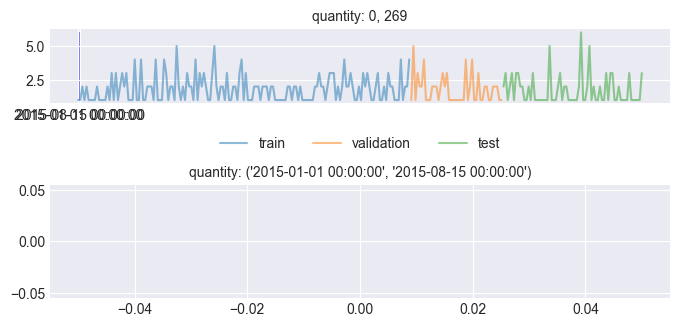

In [178]:
# Plot time series with zoom
# ==============================================================================
zoom = ('2015-01-01 00:00:00','2015-08-15 00:00:00')
data = pizza_df
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.1, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

data_train['quantity'].plot(ax=main_ax, label='train', alpha=0.5)
data_val['quantity'].plot(ax=main_ax, label='validation', alpha=0.5)
data_test['quantity'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(data['quantity'])
max_y = max(data['quantity'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))
data.loc[zoom[0]: zoom[1]]['quantity'].plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'quantity: {data.index.min()}, {data.index.max()}', fontsize=10)
zoom_ax.set_title(f'quantity: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

In [180]:
# Interactive plot of time series
# ==============================================================================
data.loc[:end_train, 'partition'] = 'train'
data.loc[end_train:end_validation, 'partition'] = 'validation'
data.loc[end_validation:, 'partition'] = 'test'

fig = px.line(
    data_frame = data.reset_index(),
    x      = 'order_date',
    y      = 'quantity',
    color  = 'partition',
    title  = 'Quantity',
    width  = 800,
    height = 450
)
fig.update_layout(
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()
data=data.drop(columns='partition')

### Seasonality plots
<br>

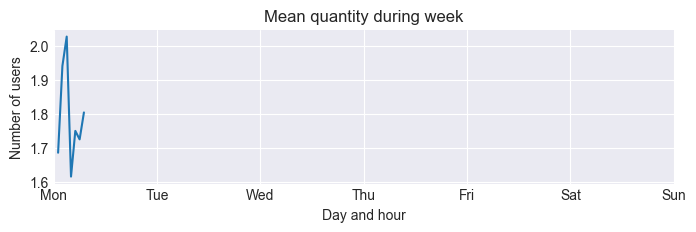

In [182]:
# Daily seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 2))
mean_day_hour = data.groupby(["weekday"])["quantity"].mean()
mean_day_hour.plot(ax=ax)
ax.set(
    title="Mean quantity during week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Day and hour",
    ylabel="Number of users"
);

There is a clear difference between weekdays and weekends. There is also a clear intra-day pattern, with different influx of users depending on the time of day.

### Autocorrelation plots
<br>

Autocorrelation plots can help identify patterns in your time series data. If the autocorrelation plot shows a high autocorrelation at a particular lag, it indicates that there is a strong relationship between observations at that lag, and therefore that lag may be a useful predictor.

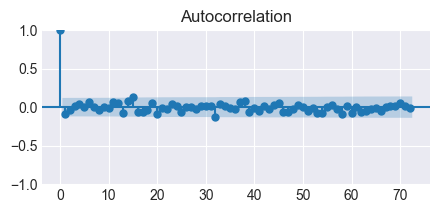

In [184]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(data['quantity'], ax=ax, lags=72)
plt.show()

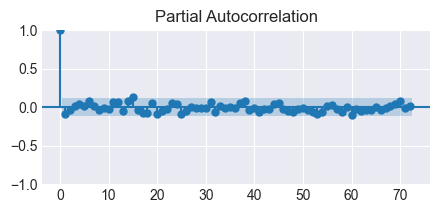

In [185]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(data['quantity'], ax=ax, lags=72, method='ywm')
plt.show()

The results of the autocorrelation study show that there is a significant correlation between the number of users in previous hours, as well as the days before, and the number of users in the future. This means that knowing the number of users during certain periods in the past could be valuable in predicting the number of users in the future.

## XGBoost
<br>

[**XGBoost**](https://xgboost.readthedocs.io/en/stable/python/python_intro.html) is a highly efficient implementation of the stochastic gradient boosting algorithm, which has become a benchmark in the field of machine learning. The XGBoost library includes its own API as well as the `XGBRegressor` class, which follows the scikit-learn API, making it compatible with skforecast.

First, an autoregressive model is trained using past values (lags) of the response variable as predictors. Later, exogenous variables are added to the model and the improvement in its performance is assessed.

Gradient Boosting models have a large number of hyperparameters, so a combination of [grid_search](https://skforecast.org/latest/user_guides/hyperparameter-tuning-and-lags-selection.html#grid-search) strategy and [backtesting](https://skforecast.org/latest/user_guides/backtesting.html) is used to identify the best configuration that gives the most accurate predictions.

<br><br>

In [186]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = xgb.XGBRegressor(random_state=123),
                 lags = 24
             )

## Hyperparameter tuning
<br>

Hyperparameter tuning is a critical step in developing effective machine learning models. It is important to note that when searching for hyperparameters, test data should not be included in the process. This is because including test data could lead to overfitting of the model.

To avoid overfitting, a search is performed where each combination of hyperparameters and lags is tested as follows:

1. Train the model using only the training set.

2. The model is evaluated using the validation set via backtesting.

3. The combination of hyperparameters and lags that gives the lowest error is selected.

4. Train the model again using the best combination found, this time using both the training and validation data.

By following these steps, one can obtain a model with optimized hyperparameters and avoid overfitting.

In [187]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'quantity'], # Train and validation data
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data_train), # Model is trained with training data
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 1.015276557443746



In [188]:
# Results of grid search
# ==============================================================================
results_grid.head()

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",1.015277,0.01,3.0,100.0
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1.022874,0.01,5.0,100.0
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",1.034705,0.01,5.0,500.0
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",1.046090,0.01,3.0,100.0
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",1.051486,0.10,5.0,500.0


Since `return_best = True`, the forecaster object will be updated with the best configuration found and trained on the entire dataset. This means that the final model obtained from the grid search will have the best combination of lags and hyperparameters that resulted in the highest performance metric. This final model can then be used for future predictions on new data.

## Backtesting test period
<br>

Once the best combination of hyperparameters has been identified **using the validation data**, the predictive capacity of the model is evaluated when applied to the test set. The `backtesting_forecaster` function is used to simulate the prediction process every 36 hours.

It is recommended to review the documentation for the [backtesting_forecaster](https://skforecast.org/latest/api/model_selection.html#skforecast.model_selection.model_selection.backtesting_forecaster) function to gain a better understanding of its capabilities. This will help to utilize its full potential to analyze the predictive capacity of the model.

In [191]:
# Backtesting on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['quantity'],
                            initial_train_size = len(data.loc[:end_validation]),
                            fixed_train_size   = False,
                            steps              = 1,
                            refit              = False,
                            metric             = 'mean_squared_error',
                            verbose            = False # Change to True to see detailed information
                      )

print(f"Backtest error: {metric:.2f}")
predictions.head()



  0%|          | 0/68 [00:00<?, ?it/s]

Backtest error: 1.22


,pred
202,1.726796
203,2.032029
204,1.712064
205,1.715598
206,1.830873


In [193]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['quantity'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Quantity",
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [196]:
%pip install pickle

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
You should consider upgrading via the 'c:\Users\ntwri\Work\farm-service\ml\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [197]:
import pickle

with open('forecaster_hawaii_m.pkl', 'wb') as f:
    pickle.dump(forecaster, f)

## Exogenous features
<br>

In addition to using autoregressive predictors obtained from the past of the response variable itself, it is possible to add other exogenous variables. In this case, calendar information (month, day of the week, time, holidays, ...) and weather variables (wind, temperature, humidity, ...) are available.



<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 6px; padding-bottom: 6px; padding-left: 6px; padding-right: 6px; border-radius: 8px; border-left: 8px solid #ff9100; padding-left: 10px;">

<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b>⚠ Warning</b>
</p>

The use of weather variables should be done with caution. When the model is deployed into production, future weather conditions are not known, but are predictions made by the meteorological services. As these are predictions, they introduce errors into the forecasting model. As a consequence, the model's predictions are likely to get worse. One way to anticipate this problem, and to know (not avoid) the expected performance of the model,  is to use the weather forecasts available at the time of model training, rather than the recorded conditions.

</div>

### Continuous features with a cyclical pattern
<br>

Continuous features that have a cyclic pattern, such as hours, can be handled in several ways, each with its advantages and disadvantages.

One approach is to use the features directly as numeric values without any transformation. This method avoids generating numerous new features but may impose an incorrect linear order on the values. For example, hour 23 of one day and hour 00 of the next are very far apart when in fact there is only one hour difference between them.

Another possibility is to treat cyclical features as categorical variables to avoid imposing a linear order. However, this approach may result in the loss of the cyclical information inherent in the variable.

There is a third way of dealing with cyclical features that is often preferred to the other two methods. This involves transforming the features using the sine and cosine of their period. This approach generates only two new features that capture the cyclicality of the data in a more accurately than the previous two methods because it preserves the natural order of the feature and avoids imposing a linear order.

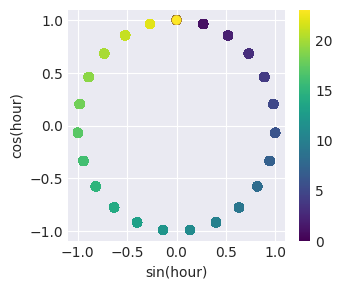

In [ ]:
# Transformation sine-cosine of variable hour
# ==============================================================================
data['hour_sin'] = np.sin(data['hour'] / 23 * 2 * np.pi)
data['hour_cos'] = np.cos(data['hour'] / 23 * 2 * np.pi)

# Plot of the transformation
# ==============================================================================
fig, ax = plt.subplots(figsize=(3.5, 3))
sp = ax.scatter(
        data["hour_sin"],
        data["hour_cos"],
        c=data["hour"],
        cmap='viridis'
     )
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)
data = data.drop(columns='hour')

### Categorical features
<br>

Although the variables 'month', 'weekday', 'weather' and 'holiday' are stored as numeric values, they are actually categorical variables. Therefore, it is important to convert their data type to categorical to prevent the model from interpreting them as numeric features. This will help ensure that the model is able to accurately capture the unique characteristics and patterns of these variables.

In [ ]:
# Store categorical variables as category type
# ==============================================================================
data["holiday"] = data["holiday"].astype("category")
data["weather"] = data["weather"].astype("category")
data["month"]   = data["month"].astype("category")
data["weekday"] = data["weekday"].astype("category")

There are several approaches to incorporating categorical variables into XGBoost (and other gradient boosting frameworks):

+ One option is to transform the data by converting categorical values to numerical values using methods such as one-hot encoding or ordinal encoding. This approach is applicable to all machine learning models.

+ Alternatively, XGBoost can handle categorical variables internally without the need for preprocessing. This can be done automatically by setting the parameter `enable_categorical='auto'` and encoding the variables as the `category` datatype within a Pandas DataFrame. Alternatively, users can specify the category type of each feature using the `feature_dtype` parameter.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; padding-left: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">🖉 Note</b>
</p>

There is no one method that always outperforms the others. General rules are:

<ul>
  <li>When the cardinality of categorical variables is high (many different values), it is better to use native support for categorical variables than to use one-hot encoding.</li><br>

  <li>With one-hot-encoded data, more split points are needed (i.e. more depth) to recover an equivalent split that could be obtained with a single split point using native handling.</li><br>
  
  <li>When a categorical variable is converted into multiple dummy variables using one-hot, its importance is diluted, making the analysis of the importance of the features more complex to interpret. </li><br>
</ul>
</div>

### One hot encoding

[ColumnTransformers in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) provide a powerful way to define transformations and apply them to specific features. By encapsulating the transformations in a `ColumnTransformer` object, it can be passed to a forecaster using the `transformer_exog` argument.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; padding-left: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">🖉 Note</b>
</p>

Applying a transformation to the entire dataset independent of the forecaster is feasible. However, it is crucial to ensure that the transformations are learned only from the training data to avoid information leakage. In addition, the same transformation should be applied to the input data during prediction. Therefore, it is advisable to include the transformation in the forecaster, so that it is handled internally. This approach ensures consistency in the application of transformations and reduces the likelihood of errors.

</div>

In [ ]:
# One hot encoding transformer
# ==============================================================================
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          make_column_selector(dtype_exclude=np.number),
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

In [ ]:
# Create forecaster with a transformer for exogenous features
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = XGBRegressor(random_state=123),
                 lags             = 24,
                 transformer_exog = one_hot_encoder
             )

To examine how the data is transformed, it is possible to use the `create_train_X_y` method to generate the matrices that the forecaster uses to train the model. This approach provides insight into the specific data manipulations that occur during the training process.

In [ ]:
# View Training Matrix
# ==============================================================================
exog_features = ['weather', 'month', 'weekday', 'hour_sin', 'hour_cos', 'holiday',
                 'temp', 'atemp', 'hum', 'windspeed']

X_train, y_train = forecaster.create_train_X_y(
                        y = data.loc[:end_validation, 'users'],
                        exog = data.loc[:end_validation, exog_features]
                   )
X_train.head(3)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,weekday_4,weekday_5,weekday_6,holiday_1.0,hour_sin,hour_cos,temp,atemp,hum,windspeed
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-02 00:00:00,39.0,28.0,34.0,36.0,37.0,35.0,67.0,93.0,110.0,106.0,...,0.0,0.0,1.0,0.0,0.000000,1.000000,18.86,22.725,88.0,19.9995
2011-01-02 01:00:00,17.0,39.0,28.0,34.0,36.0,37.0,35.0,67.0,93.0,110.0,...,0.0,0.0,1.0,0.0,0.269797,0.962917,18.04,21.970,94.0,16.9979
2011-01-02 02:00:00,17.0,17.0,39.0,28.0,34.0,36.0,37.0,35.0,67.0,93.0,...,0.0,0.0,1.0,0.0,0.519584,0.854419,17.22,21.210,100.0,19.0012


In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 8912.662678308314



In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

  0%|          | 0/82 [00:00<?, ?it/s]

Backtest error: 6329.92


### Native implementation for categorical features
<br>

Gradient Boosting libraries (**XGBoost**, **LightGBM**, **CatBoost**, and **HistGradientBoostingRegressor**) assume that the input categories are integers starting from 0 up to the number of categories [0, 1, ..., n_categories-1]. In most real cases, categorical variables are not encoded with numbers but with strings, so an intermediate transformation step is necessary. Two options are:

+ Set columns with categorical variables to the type `category`. Internally, this data structure consists of an array of categories and an array of integer values (codes) that point to the actual value of the array of categories. That is, internally it is a numeric array with a mapping that relates each value to a category. Models are able to **automatically identify** the columns of type `category` and access their internal codes. This approach is applicable to XGBoost, LightGBM and CatBoost.

+ Preprocess the categorical columns with an `OrdinalEncoder` to transform their values to integers and then **explicitly indicate** which features should be treated as categorical.

In order to use the the **automatic detection** in skforecast, categorical variables must first be encoded as integers and then stored as the type `category` again. This is because skforecast internally uses a numeric numpy array to speed up the calculation.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; padding-left: 10px;">

<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b>⚠ Warning</b>
</p>

When deploying models in production, it is strongly recommended to <b>avoid using automatic detection</b> based on pandas `category` type columns. Although pandas provides an internal coding for these columns, it is not consistent across different datasets and may vary depending on the categories present in each dataset. It is therefore crucial to be aware of this issue and to take appropriate measures to ensure consistency in the coding of categorical features when deploying models in production.

More details on this issue can be found in <a href=https://skforecast.org/latest/user_guides/categorical-features.html#native-implementation-for-categorical-features>Native implementation for categorical features</a>.

</div>

In [ ]:
# Transformer: Ordinal encoding + cast to category type
# ==============================================================================
pipeline_categorical = make_pipeline(
                            OrdinalEncoder(
                                dtype=int,
                                handle_unknown="use_encoded_value",
                                unknown_value=-1,
                                encoded_missing_value=-1
                            ),
                            FunctionTransformer(
                                func=lambda x: x.astype('category'),
                                feature_names_out= 'one-to-one'
                            )
                       )

transformer_exog = make_column_transformer(
                        (
                            pipeline_categorical,
                            make_column_selector(dtype_exclude=np.number)
                        ),
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

In [ ]:
# Create forecaster, Automatic categorical detection
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(
                                 tree_method = 'hist',
                                 enable_categorical = 'auto',
                                 random_state = 123
                             ),
                 lags = 24,
                 transformer_exog = transformer_exog
             )

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 8450.684614806387



In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

  0%|          | 0/82 [00:00<?, ?it/s]

Backtest error: 6316.78


The inclusion of exogenous variables as predictors reduced the prediction error by more than half. The results obtained using one-hot encoding (backtest error of 6330) are very similar to those obtained using the native implementation of XGBoost for categorical variables (backtest error of 6317).

## Feature importances

An advantage of avoiding one-hot encoding is that it avoids increasing the number of features, which makes interpretation easier. This can lead to simpler analysis and better understanding of the data as there are fewer variables to consider.

In [ ]:
# Extract feature importances
# ==============================================================================
importance = forecaster.get_feature_importances()
importance

,feature,importance
0,lag_1,0.303427
1,lag_2,0.005124
2,lag_3,0.002373
3,lag_4,0.010469
4,lag_5,0.006950
...,...,...
77,hour_cos,0.054678
78,temp,0.001114
79,atemp,0.001869
80,hum,0.001542


## LightGBM, CatBoost and HistGradientBoostingRegressor
<br>

Since the success of XGBoost as a machine learning algorithm, new implementations have been developed that also achieve excellent results, three of them are:

+ [**LightGBM**](https://lightgbm.readthedocs.io/en/latest/): developed by Microsoft.

+ [**HistGradientBoostingRegressor**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html): developed by scikit-learn.

+ [**CatBoost**](https://catboost.ai/): developed by Yandex.

Here is how to use them within [skforecast](https://github.com/JoaquinAmatRodrigo/skforecast).

## LightGBM

In [ ]:
# Transformer: Ordinal encoding + cast to category type
# ==============================================================================
pipeline_categorical = make_pipeline(
                           OrdinalEncoder(
                               dtype=int,
                               handle_unknown="use_encoded_value",
                               unknown_value=-1,
                               encoded_missing_value=-1
                           ),
                           FunctionTransformer(
                               func=lambda x: x.astype('category'),
                               feature_names_out= 'one-to-one'
                           )
                       )

transformer_exog = make_column_transformer(
                       (
                           pipeline_categorical,
                           make_column_selector(dtype_exclude=np.number)
                       ),
                       remainder="passthrough",
                       verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(categorical_features='auto', random_state=123),
                lags = 24,
                transformer_exog = transformer_exog
             )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(categorical_features='auto', random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'int'>,
                                                                 encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
warnings.filterwarnings('ignore')
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )
warnings.resetwarnings()

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 8496.41017952901



In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

/home/ubuntu/anaconda3/envs/cienciadedatos_p10/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning:

categorical_features in param dict is overridden.



  0%|          | 0/82 [00:00<?, ?it/s]

Backtest error: 5634.40


## HistGradientBoostingRegressor

When creating a forecaster using `HistogramGradientBoosting`, the names of the categorical columns should be specified during the instantiation of the regressor by passing them as a list to the `categorical_feature` argument.

In [ ]:
# Transformer: ordinal encoding
# ==============================================================================
# A ColumnTransformer is used to transform categorical features (no numerical)
# using ordinal encoding. Numerical features are left untouched. Missing values
# are encoded as -1. If a new category is found in the test set, it is encoded
# as -1.
categorical_features = data.select_dtypes(exclude=[np.number]).columns.tolist()
transformer_exog = make_column_transformer(
                       (
                           OrdinalEncoder(
                               dtype=int,
                               handle_unknown="use_encoded_value",
                               unknown_value=-1,
                               encoded_missing_value=-1
                           ),
                           categorical_features
                       ),
                       remainder="passthrough",
                       verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

In [ ]:
# Create forecaster
# ==============================================================================
categorical_features = data.select_dtypes(exclude=np.number).columns.to_list()

forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(
                                 categorical_features = categorical_features,
                                 random_state = 123
                             ),
                 lags = 24,
                 transformer_exog = transformer_exog
             )

forecaster

ForecasterAutoreg 
Regressor: HistGradientBoostingRegressor(categorical_features=['holiday', 'weather',
                                                    'month', 'weekday'],
                              random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder',
                                 OrdinalEncoder(dtype=<class 'int'>,
                                                encoded_missing_value=-1,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['holiday', 'weather', 'month', 'weekday'])],
                  verbose_feature_names_out=False) 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variab

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'max_iter': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 500}
  Backtesting metric: 8541.952834346452



In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

  0%|          | 0/82 [00:00<?, ?it/s]

Backtest error: 6705.14


## CatBoost
<br>

Unfortunately, the current version of skforecast is not compatible with CatBoost's built-in treatment of categorical features. The issue arises because CatBoost only accepts categorical features as integers, while skforecast converts input data to floats for faster computation using numpy arrays in the internal prediction process. To work around this limitation, it is necessary to apply either the one-hot encoding or label encoding strategy to the categorical features before using them with CatBoost.

In [ ]:
# One hot encoding
# ==============================================================================
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          make_column_selector(dtype_exclude=np.number),
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = CatBoostRegressor(
                                        random_state=123,
                                        silent=True,
                                        allow_writing_files=False
                                    ),
                 lags             = 24,
                 transformer_exog = one_hot_encoder
             )

forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x7f769ed64670> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f769ed78d30>)],
                  verbose_feature_names_out=False) 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'allow_writing_files': False, 'random_state': 123} 
fit_kwargs: {} 
Creation date: 2023-05-17 

In [ ]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [48, 72]

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   exog               = data.loc[:end_validation, exog_features],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 36,
                   refit              = False,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(data.loc[:end_train]),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 6779.454203090569



In [ ]:
# Backtesting test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['users'],
                          exog               = data[exog_features],
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 36,
                          refit              = False,
                          metric             = 'mean_squared_error',
                          verbose            = False
                      )

print(f"Backtest error: {metric:.2f}")

  0%|          | 0/82 [00:00<?, ?it/s]

Backtest error: 5801.14


## Conclusion
<br>

+ As shown in this document, the inclusion of exogenous variables as predictors can significantly improve forecasting performance.

+ The use of machine learning models in forecasting problems is very easy thanks to the functionalities offered by **skforecast**.

+ Categorical features can be included as exogenous variables.

+ The Gradient Boosting model generated by **LightGBM** performs slightly better than the other libraries in this case.


| Model                         | Exogenous features  | MSE backtest |
|:------------------------------|:-------------------:|-------------:|
| LGBMRegressor                 | True                | 5634         |
| CatBoostRegressor             | True                | 5801         |
| XGBRegressor                  | True                | 6317         |
| HistGradientBoostingRegressor | True                | 6705         |
| XGBRegressor                  | False               | 11601        |

<br><br>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; padding-left: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">🖉 Note</b>
</p>

To illustrate the process, the hyperparameter search has been kept small. However, to achieve optimal results, it may be necessary to perform a more extensive search for each model.

</div>

## Session information

In [ ]:
import session_info
session_info.show(html=False)

-----
catboost            1.1.1
lightgbm            3.3.5
matplotlib          3.6.3
numpy               1.23.5
pandas              1.5.3
plotly              5.13.1
session_info        1.0.0
skforecast          0.8.0
sklearn             1.2.2
statsmodels         0.13.5
xgboost             1.7.4
-----
IPython             8.10.0
jupyter_client      7.3.4
jupyter_core        5.2.0
-----
Python 3.10.9 (main, Jan 11 2023, 15:21:40) [GCC 11.2.0]
Linux-5.15.0-1035-aws-x86_64-with-glibc2.31
-----
Session information updated at 2023-05-17 11:11


**How to cite this document?**

<p style="text-align:left"><font size="3" color="#555">
Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM y CatBoost by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png?raw=true" /></a><br />This work by  Joaquín Amat Rodrigo and Javier Escobar Ortiz is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.